## Learning
After an initial exploratory analysis of variables that could relate to success of fast food establishments in an area, we will now use machine learning techniques to see if we can extract additional insights about what areas we should pay attention to and what features we should prioritize.

In [1]:
# required imports for our analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# load our summary dataset on fast food establishments in Philadelphia
ff_cbg_data = pd.read_csv('location_data_wrangled.csv', index_col=0)

# And begin by filtering to CBGS with fast food consumer observations
ff_cbg_data = ff_cbg_data[ff_cbg_data['Fast Food Count'] != 0]

In [2]:
# Our features
ff_cbg_data.columns

Index(['Total Population', 'Pop. that Works from Home',
       'Single Occupant Households', 'Single Parent Households',
       'Married Parent Households', 'Undergrads and Grads',
       'Diploma/GED attained', 'Degree attained', 'Households in Poverty',
       'Below 40k Earners', '40k-100k Earners', 'Above 100k Earners',
       'Unemployed', 'Renter Occupied Households', 'Owner Occupied Households',
       'Crime Counts', 'walk_score', 'transit_score', 'Fast Food Count',
       'Fast Food Consumers', 'raw_visit_count'],
      dtype='object')

We need to distinguish what sets an area apart as a particularly successful area. Lets check the distribution of consumers:

(array([67., 56., 23., 10.,  5.,  5.,  7.,  1.,  3.,  2.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  2.]),
 array([6.00000e+00, 4.18500e+02, 8.31000e+02, 1.24350e+03, 1.65600e+03,
        2.06850e+03, 2.48100e+03, 2.89350e+03, 3.30600e+03, 3.71850e+03,
        4.13100e+03, 4.54350e+03, 4.95600e+03, 5.36850e+03, 5.78100e+03,
        6.19350e+03, 6.60600e+03, 7.01850e+03, 7.43100e+03, 7.84350e+03,
        8.25600e+03, 8.66850e+03, 9.08100e+03, 9.49350e+03, 9.90600e+03,
        1.03185e+04, 1.07310e+04, 1.11435e+04, 1.15560e+04, 1.19685e+04,
        1.23810e+04]),
 <a list of 30 Patch objects>)

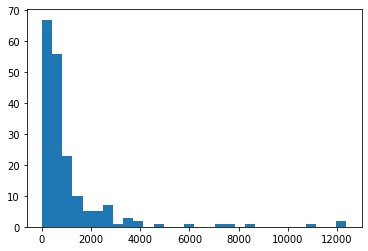

In [3]:
plt.hist(ff_cbg_data['Fast Food Consumers'], bins=30)

In [4]:
# We see that the bulk of restaurants fall before 2000, and
# that anything in the bucket from 1656 on is in appears to perform in
# excess of the average location
ff_cbg_data['Successful Location'] =\
    ff_cbg_data['Fast Food Consumers'] >= 1656

In [5]:
# Finally seperate features and output, to begin remove our potential
# output columns, and input.
output_variables = ff_cbg_data[[
    'Fast Food Count', 'Fast Food Consumers', 'Successful Location']].copy()

input_variables = ff_cbg_data.copy()
del input_variables['Fast Food Count']
del input_variables['Fast Food Consumers']
del input_variables['Successful Location']

In [6]:
# And then split out testing data for later verification
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    input_variables, output_variables, test_size=0.2,
    stratify=output_variables['Successful Location'],
    random_state=42)

In [7]:
# And as many machine learning alogorithms perform better with scaled
# data we'll prepare a scaled data set
from sklearn.preprocessing import StandardScaler

df_columns = x_train.columns

ss = StandardScaler().fit(x_train)

train_data_scaled = ss.transform(x_train)
train_data_scaled = pd.DataFrame(train_data_scaled)
train_data_scaled.columns = df_columns
x_train_scaled = train_data_scaled.copy()

test_data_scaled = ss.transform(x_test)
test_data_scaled = pd.DataFrame(test_data_scaled)
test_data_scaled.columns = df_columns
x_test_scaled = test_data_scaled.copy()

### Regression
We'll start by treating this as a regression problem on total of fast food traffic, and use cost functions to identify the most important features in predicting count of consumers in an area. Then using those identified variables we'll move on to classification to see what accuracy we can achieve in predicting if an area is a 'successful' one.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge(max_iter=1000000)
parameters = {'alpha': [.001, .01, 1, 10, 100, 1000, 10000]}
gcv = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
gcv.fit(x_train_scaled, y_train['Fast Food Consumers'])
gcv.cv_results_

/home/jon-e-pizza/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'mean_fit_time': array([0.0018146 , 0.00173001, 0.00201812, 0.00165601, 0.00159335,
        0.00157604, 0.00168352]),
 'std_fit_time': array([2.80800168e-04, 1.89720400e-04, 4.29871848e-04, 9.37175367e-05,
        3.41806108e-05, 1.72675633e-05, 1.75839506e-04]),
 'mean_score_time': array([0.00085568, 0.00103469, 0.00091791, 0.00085883, 0.0008491 ,
        0.00083876, 0.00081635]),
 'std_score_time': array([4.36203064e-05, 4.02539829e-04, 8.69161789e-05, 1.04430756e-04,
        6.86350070e-05, 4.87888540e-05, 2.61583321e-05]),
 'param_alpha': masked_array(data=[0.001, 0.01, 1, 10, 100, 1000, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000},
  {'alpha': 10000}],
 'split0_test_score': array([-0.57093007, -0.57074707, -0.55130664, -0.42021925, -0.07062769,
        -0.0357034 , -0.2298275 ]),


Our scores for different splits are all over the place. We face that even normalized our dataset may not fit a linear model very well, and that we simply don't have enough data to do a 5 split cv. We will try again with a 2 split cross validation and see if our scores are more consistent.

In [58]:
ridge = Ridge(max_iter=1000000)
parameters = {'alpha': [.001, .01, 1, 10, 100, 1000, 10000]}
gcv = GridSearchCV(ridge, parameters, scoring='r2', cv=2)
gcv.fit(x_train_scaled, y_train['Fast Food Consumers'])
gcv.cv_results_

/home/jon-e-pizza/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'mean_fit_time': array([0.00246251, 0.00165427, 0.00168359, 0.00166988, 0.00163472,
        0.00163209, 0.00161469]),
 'std_fit_time': array([1.15513802e-04, 1.15633011e-05, 4.04119492e-05, 2.86102295e-05,
        3.93390656e-06, 2.27689743e-05, 2.77757645e-05]),
 'mean_score_time': array([0.00098646, 0.00090814, 0.00083637, 0.00083053, 0.00083208,
        0.00080144, 0.00081265]),
 'std_score_time': array([1.48415565e-04, 3.09944153e-06, 8.58306885e-06, 2.39610672e-05,
        4.38690186e-05, 1.13248825e-05, 4.88758087e-06]),
 'param_alpha': masked_array(data=[0.001, 0.01, 1, 10, 100, 1000, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000},
  {'alpha': 10000}],
 'split0_test_score': array([-0.32892673, -0.32824975, -0.26835534, -0.09632725,  0.10138035,
         0.05428803, -0.01786366]),


Our $R^2$s seem to converge a lot better with just two folds. Lets see the coefficients for the best model:

In [59]:
pd.DataFrame({'Variable': x_train_scaled.columns, 'Coefficients': gcv.best_estimator_.coef_})

,Variable,Coefficients
0,Total Population,123.193747
1,Pop. that Works from Home,86.202973
2,Single Occupant Households,-5.312446
3,Single Parent Households,-111.949563
4,Married Parent Households,-35.398090
5,Undergrads and Grads,348.164158
6,Diploma/GED attained,22.274591
7,Degree attained,-60.861319
8,Households in Poverty,-59.668802
9,Below 40k Earners,1.176450


This model clearly emphasizes 'raw_visit_count' and 'Undergrads and Grads'. The following metrics of note are 'transit_score', and 'Crime Counts', and then a little after that 'Total Population' and 'Single Parent Households'. Lets see how linear regression on just there variables fares:

In [60]:
from sklearn.linear_model import LinearRegression

x_train_subset = x_train[['Undergrads and Grads', 'raw_visit_count']].copy()
x_test_subset = x_test[['Undergrads and Grads', 'raw_visit_count']].copy()
lm = LinearRegression()
lm.fit(x_train_subset, y_train['Fast Food Consumers'])
tr_score = lm.score(x_train_subset, y_train['Fast Food Consumers'])
te_score = lm.score(x_test_subset, y_test['Fast Food Consumers'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))

Model score on training data: 0.5068456980713572
Model score on testing data: 0.5564381747231268


In [61]:
from sklearn.linear_model import LinearRegression

x_train_subset = x_train[[
    'Total Population', 'Undergrads and Grads',
    'transit_score', 'Crime Counts']].copy()
x_test_subset = x_test[[
    'Total Population', 'Undergrads and Grads',
    'transit_score', 'Crime Counts']].copy()
lm = LinearRegression()
lm.fit(x_train_subset, y_train['Fast Food Consumers'])
tr_score = lm.score(x_train_subset, y_train['Fast Food Consumers'])
te_score = lm.score(x_test_subset, y_test['Fast Food Consumers'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))

Model score on training data: 0.3464531131041542
Model score on testing data: 0.5829130153209574


In [62]:
from sklearn.linear_model import LinearRegression

x_train_subset = x_train[[
    'Total Population', 'Undergrads and Grads',
    'transit_score', 'Crime Counts', 'raw_visit_count',
    'Single Parent Households']].copy()
x_test_subset = x_test[[
    'Total Population', 'Undergrads and Grads',
    'transit_score', 'Crime Counts', 'raw_visit_count',
    'Single Parent Households']].copy()
lm = LinearRegression()
lm.fit(x_train_subset, y_train['Fast Food Consumers'])
tr_score = lm.score(x_train_subset, y_train['Fast Food Consumers'])
te_score = lm.score(x_test_subset, y_test['Fast Food Consumers'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))

Model score on training data: 0.5312462031431116
Model score on testing data: 0.5524097924369016


Of the varying levels of influence, it truly does appear a model based on just 'Undergrads and Grads' and 'raw_visit_count' performs best with $R^2$ score over .5 on both training and testing data, while the introduction of the other variables causes the model too fall noticably in performance on the training data.

For another datapoint, we try the Lasso cost function to see if the variables it emphasizes performs better.

In [15]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=1000000)
parameters = {'alpha': [.001, .01, 1, 10, 100, 1000, 10000]}
gcv = GridSearchCV(lasso, parameters, scoring='r2', cv=2)
gcv.fit(x_train_scaled, y_train['Fast Food Consumers'])
gcv.cv_results_

/home/jon-e-pizza/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'mean_fit_time': array([1.21149743, 0.1221509 , 0.00327468, 0.00195396, 0.00160086,
        0.00157893, 0.00156236]),
 'std_fit_time': array([2.95332789e-01, 3.03814411e-02, 3.89575958e-04, 1.33156776e-04,
        7.74860382e-06, 2.49147415e-05, 1.43051147e-06]),
 'mean_score_time': array([0.00108898, 0.00084114, 0.00082064, 0.0008086 , 0.00081873,
        0.00079632, 0.00079596]),
 'std_score_time': array([7.74860382e-06, 1.85966492e-05, 1.04904175e-05, 1.01327896e-05,
        2.38418579e-06, 1.43051147e-06, 3.57627869e-07]),
 'param_alpha': masked_array(data=[0.001, 0.01, 1, 10, 100, 1000, 10000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000},
  {'alpha': 10000}],
 'split0_test_score': array([-0.32899292, -0.32891006, -0.31961928, -0.24101115, -0.01700314,
         0.04958837, -0.03013447]),


In [16]:
pd.DataFrame({'Variable': x_train_scaled.columns, 'Coefficients': gcv.best_estimator_.coef_})

,Variable,Coefficients
0,Total Population,-175.791793
1,Pop. that Works from Home,39.385199
2,Single Occupant Households,-54.996133
3,Single Parent Households,0.000000
4,Married Parent Households,6.218625
5,Undergrads and Grads,735.429668
6,Diploma/GED attained,96.407597
7,Degree attained,-57.130900
8,Households in Poverty,-0.000000
9,Below 40k Earners,43.315443


This model again suggests that 'Undergrads and Grads' and 'raw_visit_count' are the most important features, and also supports 'transit_score' as important, but Lasso seems to emphasize 'Diploma/GED attained' and 'Above 100k Earners' where Ridge did not. We'll see how a model on these variables fits.

In [17]:
x_train_subset = x_train[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()
x_test_subset = x_test[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()
lm = LinearRegression()
lm.fit(x_train_subset, y_train['Fast Food Consumers'])
tr_score = lm.score(x_train_subset, y_train['Fast Food Consumers'])
te_score = lm.score(x_test_subset, y_test['Fast Food Consumers'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))

Model score on training data: 0.5449707241830134
Model score on testing data: 0.5661148734273115


And this model actually seems to generalize best of our linear models, so this might be our best set of features. But just for one last input with the linear model, we use RFE to rank our features.

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

rfe = RFECV(lm, cv=2)
rfe.fit(x_train_scaled, y_train['Fast Food Consumers'])
pd.DataFrame({'Variable': x_train_scaled.columns, 'Ranking': rfe.ranking_})

,Variable,Ranking
0,Total Population,3
1,Pop. that Works from Home,11
2,Single Occupant Households,5
3,Single Parent Households,12
4,Married Parent Households,13
5,Undergrads and Grads,1
6,Diploma/GED attained,8
7,Degree attained,18
8,Households in Poverty,14
9,Below 40k Earners,4


But this method doesn't reveal more than just 'raw_visit_count' and 'Undergrads and Grads' stand above all other features in prediction.

Before switching to approach this as a classification problem, we first turn to decision tree regressors to see if we can produce a better fitting model if we abandon our linear constraints. Note we don't have to use our scaled dataset with our tree model.

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=350, random_state=42)
forest.fit(x_train, y_train['Fast Food Consumers'])
tr_score = forest.score(x_train, y_train['Fast Food Consumers'])
te_score = forest.score(x_test, y_test['Fast Food Consumers'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))
df = pd.DataFrame({'Variable': x_train.columns, 'Coefficient': forest.feature_importances_})

Model score on training data: 0.8923444516415268
Model score on testing data: 0.6063601876394138


And perhaps as expected our tree based model scores better than our linear model on both training and test data. Additionally, our regressor continues to emphasize 'Undergrads and Grads' and 'raw_visit_count', and 'Crime Counts' is again seen as a runner up, but then this model is the first to point to the predictive power of 'Households in Poverty', and 'Below 40k Earners'. We will take note of this when sampling variables for our classifiers.

Before turning to our classifiers though, we see if a GradientBoosting algorithm on our trees can increase our prediction power.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 100, max_depth=5, learning_rate=.01, random_state=42)
gbr.fit(x_train, y_train['Fast Food Consumers'])

tr_score = gbr.score(x_train, y_train['Fast Food Consumers'])
te_score = gbr.score(x_test, y_test['Fast Food Consumers'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))

pd.DataFrame({'Variable': x_train.columns, 'Feature Importance': gbr.feature_importances_})

Model score on training data: 0.8161663182048728
Model score on testing data: 0.5897843086228176


,Variable,Feature Importance
0,Total Population,0.018210
1,Pop. that Works from Home,0.013704
2,Single Occupant Households,0.008220
3,Single Parent Households,0.001857
4,Married Parent Households,0.003450
5,Undergrads and Grads,0.472460
6,Diploma/GED attained,0.039818
7,Degree attained,0.099454
8,Households in Poverty,0.027791
9,Below 40k Earners,0.004061


We don't see any increase in predictive power, but we do see 'Degree attained' as a surprisingly important feature for prediction.

Since our random forest regressor seemed to be the best fit for predicting consumership, and our goal is to predict where we should open restaurants, we also want to have a model to know where there are fewer establishments than could be predicted. To predict this count of restaurants we probably want to actually use the fast food consumers as a predictor, so we'll add that to our previous best performing Random Forest model with the variables that were emphasized there:

In [34]:
x_train_count = x_train[['Total Population', 'Undergrads and Grads', 
    'Degree attained', 'Households in Poverty', 'Below 40k Earners',
    'Crime Counts', 'walk_score', 'raw_visit_count']].copy()
x_train_count['Fast Food Consumers'] = y_train['Fast Food Consumers']

x_test_count = x_test[['Total Population', 'Undergrads and Grads',
    'Degree attained', 'Households in Poverty', 'Below 40k Earners',
    'Crime Counts', 'walk_score', 'raw_visit_count']].copy()
x_test_count['Fast Food Consumers'] = y_test['Fast Food Consumers']

forest = RandomForestRegressor(n_estimators=350, random_state=42)
forest.fit(x_train_count, y_train['Fast Food Count'])
tr_score = forest.score(x_train_count, y_train['Fast Food Count'])
te_score = forest.score(x_test_count, y_test['Fast Food Count'])
print('Model score on training data: {}'.format(tr_score))
print('Model score on testing data: {}'.format(te_score))
pd.DataFrame({'Variable': x_train_count.columns, 'Coefficient': forest.feature_importances_})

Model score on training data: 0.9423576879469737
Model score on testing data: 0.05862344704305067


,Variable,Coefficient
0,Total Population,0.031844
1,Undergrads and Grads,0.052583
2,Degree attained,0.027531
3,Households in Poverty,0.063509
4,Below 40k Earners,0.051631
5,Crime Counts,0.134555
6,walk_score,0.028563
7,raw_visit_count,0.066670
8,Fast Food Consumers,0.543114


The very different $R^2$ scores between training and testing data for this regressor may indicate it generalizes too poorly to be a useful model, but if we can trust it we would like to determine where the current establishment count is lower than predicted as places where we might want to make a new location:

In [22]:
pc = pd.DataFrame({
    'Fast Food Count': y_train['Fast Food Count'].astype(int),
    'Predicted Count': forest.predict(x_train_count).astype(int),
    'Successful Location': y_train['Successful Location']})
pc[pc['Successful Location'] & (pc['Fast Food Count']<pc['Predicted Count'])]

,Fast Food Count,Predicted Count,Successful Location
421010004011,3,4,True
421010312002,1,2,True


In [35]:
pc = pd.DataFrame({
    'Fast Food Count': y_test['Fast Food Count'].astype(int),
    'Predicted Count': forest.predict(x_test_count).astype(int),
    'Successful Location': y_test['Successful Location']})
pc[pc['Successful Location'] & (pc['Fast Food Count']<pc['Predicted Count'])]

,Fast Food Count,Predicted Count,Successful Location
421010377001,2,4,True
421010379003,4,5,True
421010146001,3,4,True
421010369003,4,5,True
421010010011,2,4,True


And our model points us to two locations where we might want to start a new fast food establishment, though again we might take this with a grain of salt due to low score on testing data.

### Classification

Now we'll start seeing how our classification algorithms perform with our discovered top subsets of features. We'll start with seeing how well we can predict success with linear models (logistic regression, SVM) as before, then see how a perceptron based classifier performs, then move again on to tree models, then kNearest Neighbors, and finally see what a naive bayes predictor can produce.

We'll use our best linear model variables from lasso for our linear classifiers. For each classifier we'll output the recall (how many of the successful locations we identified), the precision (how many of the successful locations we predicted were actually confirmed as such), and the Area under the receiver operator curve (relative tradeoff of true positives to false positives).

In [9]:
# first we aim to use a logistic regression model. As our best scoring
# linear model was produced by our Lasso Cost function, we'll use those
# variables in particular for our linear logisitic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

x_train_subset = x_train_scaled[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()
x_test_subset = x_test_scaled[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], logreg.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], logreg.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], logreg.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], logreg.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], logreg.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], logreg.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.32, a precision score of 0.8, and an area under receiver operating curve score of 0.85 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.71 on the test data.


Despite less than stellar performance on the training data, it is good to see a precision of 1 on our test data predictions, and our AUC score does indicate a fairly good classifier (especially on the training data).

Next we'll see if we can predict better with a SVM and a RBF kernel to try to predict with higher order variables.

In [33]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True)
parameters = ({'C': [0.1, 1, 10, 100], 'gamma':  [0.1, 1, 10, 100]})

gcv = GridSearchCV(svm, parameters, cv=2, iid=True)
gcv.fit(x_train_subset, y_train['Successful Location'])

y_train_pred = gcv.best_estimator_.predict(x_train_subset)
y_train_ppred = gcv.best_estimator_.predict_proba(x_train_subset)
y_test_pred = gcv.best_estimator_.predict(x_test_subset)
y_test_ppred = gcv.best_estimator_.predict_proba(x_test_subset)
print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], y_train_pred)) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], y_train_pred)) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], y_train_ppred[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], y_test_pred)) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], y_test_pred)) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], y_test_ppred[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.32, a precision score of 1.0, and an area under receiver operating curve score of 0.93 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.87 on the test data.


With the SVM model the recall and precision don't change much from our logistic regression, the roc auc on the predicted probabilities however indicates a more confident model in predicting successful areas.

We'll now switch from linear models to reduce the bias of our estimators, perhaps at the cost of increased variance in our predictions.

We'll first feed our full set of variables into a perceptron based learning model and see how well this model predicts our success class.

In [10]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=10000, random_state=42, hidden_layer_sizes=[100,100])
mlp.fit(x_train_scaled, y_train['Successful Location'])
mlp.score(x_train_scaled, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], mlp.predict(x_train_scaled))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], mlp.predict(x_train_scaled))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], mlp.predict_proba(x_train_scaled)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], mlp.predict(x_test_scaled))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], mlp.predict(x_test_scaled))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], mlp.predict_proba(x_test_scaled)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 1.0, a precision score of 1.0, and an area under receiver operating curve score of 1.00 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.77 on the test data.


And just for a point of comparison we try training with just our Lasso selected variables.

In [11]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=10000, random_state=42, hidden_layer_sizes=[100,100])
mlp.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], mlp.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], mlp.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], mlp.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], mlp.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], mlp.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], mlp.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 1.0, a precision score of 1.0, and an area under receiver operating curve score of 1.00 on the training data.
This classifier has a recall score of 0.6666666666666666, a precision score of 1.0, and an area under receiver operating curve score of 0.86 on the test data.


We can use the eli5 library to get an idea of the importance of our different features in this classifier:

In [53]:
import eli5
from eli5.sklearn import PermutationImportance

In [21]:
perm = PermutationImportance(mlp).fit(x_test_subset, y_test['Successful Location'])
eli5.show_weights(perm)

Weight,Feature
0.1421 ± 0.0421,x1
0.0737 ± 0.0394,x7
0.0526 ± 0.0333,x4
0.0316 ± 0.0516,x6
0.0316 ± 0.0516,x2
0.0263 ± 0.0000,x3
0.0158 ± 0.0258,x0
0.0105 ± 0.0258,x5


In [55]:
df = pd.DataFrame({'Variable': ['Total Population', 'Undergrads and Grads', 'Diploma/GED attained',
       'Above 100k Earners', 'Crime Counts', 'walk_score', 'transit_score',
       'raw_visit_count'],b
        'Coefficient': [0.0158, 0.1421, 0.0316, 0.0263, 0.0526, 0.0105, 0.0316, 0.0737]})

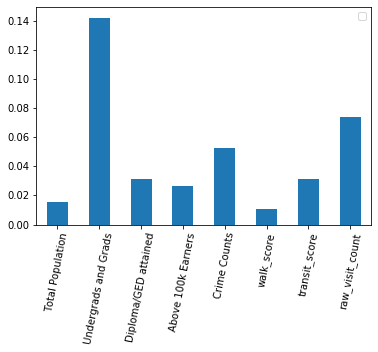

In [57]:
_ = df.plot.bar('Variable', 'Coefficient')
plt.legend('')
plt.xlabel('')
plt.xticks(rotation=79)
plt.show()

Both our perceptron based methods have better recall than our previous linear models on the training data, while the one with our subset of variables also increases recall on the testing data, as well as resulting in a better roc auc score. Both have the difference in recall and auc between training data and test data that may indicate overfitting though. Lets see if we can produce another model that appears to generalize better.

We can use the tree based classifiers with the full data set. We'll first try the RandomForestClassifier:

In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 350, random_state=42)
rfc.fit(x_train, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], rfc.predict(x_train))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], rfc.predict(x_train))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], rfc.predict_proba(x_train)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], rfc.predict(x_test))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], rfc.predict(x_test))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], rfc.predict_proba(x_test)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 1.0, a precision score of 1.0, and an area under receiver operating curve score of 1.00 on the training data.
This classifier has a recall score of 0.5, a precision score of 0.6, and an area under receiver operating curve score of 0.90 on the test data.


But we see we lose precision on our test data set while precision may be the most important metric to us, even as we do achieve a rather high auc score on the test data. We want to know any predicted successful location is in fact in that class, even if we might miss predicting some. We'll try again with the subset of Lasso variables as we did with MLP, though we can continue to not use the scaled variables with this tree classifier.

In [39]:
from sklearn.ensemble import RandomForestClassifier

x_train_subset = x_train[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()
x_test_subset = x_test[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()

rfc = RandomForestClassifier(n_estimators = 350, random_state=42)
rfc.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], rfc.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], rfc.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], rfc.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], rfc.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], rfc.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], rfc.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 1.0, a precision score of 1.0, and an area under receiver operating curve score of 1.00 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.92 on the test data.


And though we don't have the recall score of our MLP model, we do have our desired precision, and a auc curve indicating a truly superior model.

Next we try the gradient boosting classifier with the full variable set.

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators = 100, max_depth=5, learning_rate=.1, random_state=42)
gbc.fit(x_train, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], gbc.predict(x_train))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], gbc.predict(x_train))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], gbc.predict_proba(x_train)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], gbc.predict(x_test))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], gbc.predict(x_test))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], gbc.predict_proba(x_test)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 1.0, a precision score of 1.0, and an area under receiver operating curve score of 1.00 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.91 on the test data.


We already do as well as the Random Forest with the subset of variables. Lets see what this model predicted for the most important variables:

In [34]:
pd.DataFrame({'Variable': x_train.columns, 'Feature Importance': gbc.feature_importances_})

,Variable,Feature Importance
0,Total Population,0.016339
1,Pop. that Works from Home,0.005981
2,Single Occupant Households,0.010277
3,Single Parent Households,0.070895
4,Married Parent Households,0.065954
5,Undergrads and Grads,0.303830
6,Diploma/GED attained,0.034028
7,Degree attained,0.052723
8,Households in Poverty,0.002279
9,Below 40k Earners,0.001621


We see the features that are emphasized here are:
<li>Undergrads and Grads</li>
<li>raw_visit_count</li>
<li>Crime Counts</li>
<li>walk_score</li>
<li>Single Parent Households</li>
<li>Married Parent Households</li>

We can also try our previous subset as input again:

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators = 100, max_depth=5, learning_rate=.1, random_state=42)
gbc.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], gbc.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], gbc.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], gbc.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], gbc.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], gbc.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], gbc.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 1.0, a precision score of 1.0, and an area under receiver operating curve score of 1.00 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.91 on the test data.


But see no gain in doing this, so we'll try both our best set of linear predictors, and the features emphasized by the gradient boosted classifier on the full set of variables in evaluating a k nearest neighbors classifier, returning to our scaled data sets for this location based algorithm.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

x_train_subset = x_train_scaled[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()
x_test_subset = x_test_scaled[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], knn.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], knn.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.48, a precision score of 0.8571428571428571, and an area under receiver operating curve score of 0.93 on the training data.
This classifier has a recall score of 0.5, a precision score of 0.75, and an area under receiver operating curve score of 0.69 on the test data.


This model is certainly not our best, so we try the gradient boosting emphasized variables:

In [43]:
x_train_subset = x_train_scaled[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count']].copy()
x_test_subset = x_test_scaled[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count']].copy()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], knn.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], knn.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.48, a precision score of 0.8, and an area under receiver operating curve score of 0.94 on the training data.
This classifier has a recall score of 0.6666666666666666, a precision score of 1.0, and an area under receiver operating curve score of 0.78 on the test data.


And we get back to a precision of 1 on our test data, but our auc scores are still lacking behind our best models, so we try adding our previously emphasized variables from our best regressor 

In [44]:
x_train_subset = x_train_scaled[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count', 'Households in Poverty', 'Below 40k Earners']].copy()
x_test_subset = x_test_scaled[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count', 'Households in Poverty', 'Below 40k Earners']].copy()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], knn.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], knn.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.6, a precision score of 0.9375, and an area under receiver operating curve score of 0.96 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.70 on the test data.


The notably higher precision on the training data here may actually make this a more preferable model since we emphasize the value of precision, even as our recall falls on our test data, but we're still not beating our gradient boosting model.

Just for one last point we see if we produce a better model with a union of the linear and gradient boosting variables:

In [45]:
x_train_subset = x_train_scaled[[
    'Total Population',
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Renter Occupied Households', 'Diploma/GED attained', 'Above 100k Earners',
    'Crime Counts', 'walk_score', 'transit_score', 'raw_visit_count']].copy()
x_test_subset = x_test_scaled[[
    'Total Population',
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Renter Occupied Households', 'Diploma/GED attained', 'Above 100k Earners',
    'Crime Counts', 'walk_score', 'transit_score', 'raw_visit_count']].copy()

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], knn.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], knn.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], knn.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], knn.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.4, a precision score of 0.8333333333333334, and an area under receiver operating curve score of 0.94 on the training data.
This classifier has a recall score of 0.5, a precision score of 1.0, and an area under receiver operating curve score of 0.70 on the test data.


And we lost on recall scores for both training and test data, so it seem we do better with the gradient boosted chosen variables. We'll keep the better variable set then, and see if we can summarize something more generalizeable from PCA.

<BarContainer object of 8 artists>

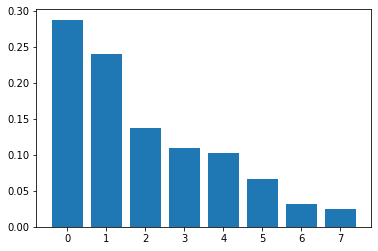

In [47]:
# First lets examine contribution to variance
# on each component
from sklearn.decomposition import PCA

x_train_subset = x_train_scaled[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count', 'Households in Poverty', 'Below 40k Earners']].copy()
x_test_subset = x_test_scaled[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count', 'Households in Poverty', 'Below 40k Earners']].copy()

pca = PCA()
pca.fit(x_train_subset)
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

It seems we have the greatest fall off in explained variance after the 6th component, so we try predicting with this many components, still using the knn classifier which has given us the most success thus far.

In [49]:
pca = PCA(n_components=6)
x_train_pca = pca.fit(x_train_subset)
x_train_pca = pca.transform(x_train_subset)
x_test_pca = pca.transform(x_test_subset)


knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_pca, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], knn.predict(x_train_pca))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], knn.predict(x_train_pca))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], knn.predict_proba(x_train_pca)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], knn.predict(x_test_pca))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], knn.predict(x_test_pca))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], knn.predict_proba(x_test_pca)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.52, a precision score of 0.9285714285714286, and an area under receiver operating curve score of 0.95 on the training data.
This classifier has a recall score of 0.5, a precision score of 0.75, and an area under receiver operating curve score of 0.70 on the test data.


But a loss in precision turns us away from using PCA for our model.

Before seeing how we can cluster on various features, we have one more available non linear classification algorithm to try. We'll try a Gaussian NaiveBayes approach on our unscaled data using our two better performing variable subsets that produced our best models above.

In [50]:
from sklearn.naive_bayes import GaussianNB

x_train_subset = x_train[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()
x_test_subset = x_test[[
    'Total Population', 'Undergrads and Grads',
    'Diploma/GED attained', 'Above 100k Earners', 'Crime Counts',
    'walk_score', 'transit_score', 'raw_visit_count']].copy()

gnb = GaussianNB()
gnb.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], gnb.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], gnb.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], gnb.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], gnb.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], gnb.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], gnb.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.44, a precision score of 0.55, and an area under receiver operating curve score of 0.82 on the training data.
This classifier has a recall score of 0.5, a precision score of 0.6, and an area under receiver operating curve score of 0.90 on the test data.


In [51]:
from sklearn.naive_bayes import GaussianNB

x_train_subset = x_train[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count']].copy()
x_test_subset = x_test[[
    'Married Parent Households', 'Single Parent Households', 'Undergrads and Grads',
    'Crime Counts', 'walk_score', 'raw_visit_count']].copy()

gnb = GaussianNB()
gnb.fit(x_train_subset, y_train['Successful Location'])

print('This classifier has a recall score of {}'.format(
      recall_score(y_train['Successful Location'], gnb.predict(x_train_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_train['Successful Location'], gnb.predict(x_train_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_train['Successful Location'], gnb.predict_proba(x_train_subset)[:,1])) +
      ' on the training data.')
print('This classifier has a recall score of {}'.format(
      recall_score(y_test['Successful Location'], gnb.predict(x_test_subset))) +
      ', a precision score of {}'.format(
      precision_score(y_test['Successful Location'], gnb.predict(x_test_subset))) +
      ', and an area under receiver operating curve score of {:.2f}'.format(
      roc_auc_score(y_test['Successful Location'], gnb.predict_proba(x_test_subset)[:,1])) +
      ' on the test data.')

This classifier has a recall score of 0.4, a precision score of 0.5263157894736842, and an area under receiver operating curve score of 0.75 on the training data.
This classifier has a recall score of 0.5, a precision score of 0.6, and an area under receiver operating curve score of 0.90 on the test data.


But we simply don't get a good model from the GaussianNB classifiers. At the end a prediction of successful from our RandomForestClassifier with the subset of variables we got from Lasso best predicts successful locations.

### Unsupervised Learning

We now turn to clustering our different Census Block Groups. Our primary interest in this segmentation is to produce clusters where fast food consumption is high, as these will be our target customer segments.

We will cluster on the entire data set first and see if any cluster comes out with distinctly higher amounts of successful fast food locations. If so we want to record any other trends we can find in that cluster.

We will then follow up clustering on just our best predicting PCA vectors, than map any successful clusters points back to their original observations and again look for trends.

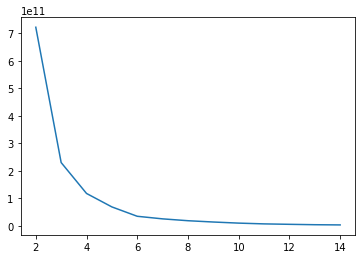

In [42]:
from sklearn.cluster import KMeans

cluster_sses = []
for i in range(2,15):
    kme = KMeans(n_clusters = i, random_state=42)
    kme.fit(x_train)
    cluster_sses.append(kme.inertia_)

plt.plot(np.arange(2,15), cluster_sses)

The steep falls in Sum of Squares to the centroids going from 2 to 4 clusters indicateds there are likely at least this many intrinsic clusterings in the data, while the fall proceeding 4 clusters is much more shallow, so we choose 4 as our cluster count to segment on.

In [43]:
kme = KMeans(n_clusters = 4, random_state=42)
kme.fit(x_train)
ct = pd.crosstab(y_train['Successful Location'], kme.predict(x_train))
ct

col_0,0,1,2,3
Successful Location,,,,
False,14,0,108,2
True,7,1,15,2


In [44]:
print('The expected proportion of successful fast food locations is {}'.format(
    y_train['Successful Location'].sum() / len(y_train)))

The expected proportion of successful fast food locations is 0.16778523489932887


We do seem to have segmented off populations that are more likely to attract fast food visitors. Lets compare the centers of each population to see if the less successful cluster 2 stands out from the other three variables.

In [45]:
centers = pd.DataFrame(kme.cluster_centers_)
centers.columns = x_train.columns
centers

,Total Population,Pop. that Works from Home,Single Occupant Households,Single Parent Households,Married Parent Households,Undergrads and Grads,Diploma/GED attained,Degree attained,Households in Poverty,Below 40k Earners,40k-100k Earners,Above 100k Earners,Unemployed,Renter Occupied Households,Owner Occupied Households,Crime Counts,walk_score,transit_score,raw_visit_count
0,1510.761905,24.190476,318.714286,29.761905,61.285714,239.238095,296.428571,401.809524,647.380952,292.190476,209.952381,145.238095,56.000000,383.666667,263.714286,370.380952,76.142857,72.190476,1.658243e+05
1,2451.000000,36.000000,602.000000,0.000000,29.000000,418.000000,558.000000,604.000000,874.000000,432.000000,262.000000,180.000000,119.000000,824.000000,50.000000,1877.000000,99.000000,100.000000,1.875000e+06
2,1289.178862,19.609756,185.170732,61.479675,56.674797,187.991870,253.430894,231.504065,475.756098,220.227642,168.918699,86.609756,67.357724,235.747967,240.008130,139.252033,81.585366,71.146341,4.548543e+04
3,1597.750000,85.750000,530.000000,5.500000,39.500000,206.000000,91.500000,949.000000,959.500000,185.750000,372.000000,401.750000,47.750000,545.000000,414.500000,770.250000,94.250000,95.250000,3.606030e+05


Judging cluster 2 as standing out when it is either the highest or lowest in a category, and defining our market segmentation for fast food restaurants as the opposite of cluster 2's position, we arrive at locations where fast food restaurants might have more appeal generally have populations with more:
<li>Total Population</li>
<li>Population that Works from Home</li>
<li>Single Occupant Households</li>
<li>Undergrads and Grads</li>
<li>Degree Attained</li>
<li>Households in Poverty</li>
<li>40k-100k Earners</li>
<li>Above 100k Earners</li>
<li>Renter Occupied Households</li>
<li>Crime Counts</li>
<li>raw_visit_count</li>

and fewer:
<li>Single Parent Households</li>

But having to keep in mind that our strongest aligned clusters are only 1 and 2 neighborhoods, which is not the sign of a good generalizable model. Lets instead cluster by our former PCA groupings which produced our most generalized model and if we get a better clustering, see what our segments look like then when we take it back to the full variable set.

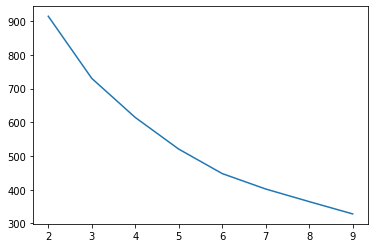

In [46]:
from sklearn.cluster import KMeans

cluster_sses = []
for i in range(2,10):
    kme = KMeans(n_clusters = i, random_state=42)
    kme.fit(x_train_pca)
    cluster_sses.append(kme.inertia_)

plt.plot(np.arange(2,10), cluster_sses)

In [47]:
kme = KMeans(n_clusters = 6, random_state=42)
kme.fit(x_train_pca)
ct = pd.crosstab(y_train['Successful Location'], kme.predict(x_train_pca))
ct

col_0,0,1,2,3,4,5
Successful Location,,,,,,
False,16,14,64,29,0,1
True,4,2,9,2,2,6


Here Cluster 5 looks like it will be a more trustworthy indicator of what makes an area attractive to fast food, so we'll align our original training set with these clusters and see if the in cluster means stand out for cluster 5 and 4.

In [48]:
pca_cluster = x_train.copy()
pca_cluster['cluster'] = kme.predict(x_train_pca)
pca_cluster.groupby('cluster').mean()

,Total Population,Pop. that Works from Home,Single Occupant Households,Single Parent Households,Married Parent Households,Undergrads and Grads,Diploma/GED attained,Degree attained,Households in Poverty,Below 40k Earners,40k-100k Earners,Above 100k Earners,Unemployed,Renter Occupied Households,Owner Occupied Households,Crime Counts,walk_score,transit_score,raw_visit_count
cluster,,,,,,,,,,,,,,,,,,,
0,1806.450000,22.900000,277.500000,46.400000,133.800000,103.550000,484.350000,337.900000,751.750000,288.550000,315.250000,147.950000,81.950000,307.400000,444.350000,142.450000,55.550000,52.800000,6.458595e+04
1,1556.250000,53.625000,514.312500,11.937500,43.062500,310.125000,159.000000,721.000000,881.312500,301.250000,276.875000,303.187500,50.437500,637.562500,243.750000,372.812500,96.937500,93.375000,1.649044e+05
2,958.054795,15.301370,143.013699,34.410959,45.013699,93.575342,205.246575,211.767123,369.301370,162.000000,131.479452,75.821918,53.643836,170.260274,199.041096,119.041096,83.863014,71.890411,5.123564e+04
3,1625.354839,9.483871,191.741935,145.580645,54.741935,96.967742,326.967742,153.032258,548.903226,332.419355,170.096774,46.387097,94.612903,279.806452,269.096774,233.645161,81.677419,68.548387,5.352410e+04
4,2210.500000,59.000000,784.500000,0.000000,26.500000,334.000000,348.500000,976.000000,1154.500000,384.000000,491.000000,279.500000,78.500000,768.500000,386.000000,1819.500000,99.500000,100.000000,1.182032e+06
5,1909.000000,64.857143,65.571429,9.285714,6.285714,1693.000000,39.142857,123.428571,200.714286,129.857143,49.714286,21.142857,45.571429,152.714286,48.000000,211.142857,85.000000,89.285714,1.001040e+05


Assuming we have two distinct clusterings, first we can look at the clustering for cluster 5 and determine that the description of one of our target segment neighborhoods is that it:
Has a high count of:
<li>Population that Works from Home</li>
<li>Undergrads and Grads</li>
    
And low count of:
<li>Single Occupant Households</li>
<li>Single Parent Households</li>
<li>Married Parent Households</li>
<li>Diploma/GED as Highest Educational Attainment</li>
<li>Households in Poverty</li>
<li>Income Earners of any Tier</li>
<li>Owner Occupied Households</li>

Which all correlates fairly well with a high population of higher education students.

Meanwhile Cluster 4 identifies another successful segment of neighborhoods as characterized by
(and being mindful of higher population against which cluster charicterizations should be weighed)
High:
<li>Single Occupant Households</li>
<li>Degree attained population</li>
<li>Households in Poverty</li>
<li>40-100k Earners</li>
<li>Renter Occupied Households</li>
<li>Crime Counts</li>
<li>Walk Score</li>
<li>transit_score</li>
<li>raw_visit_count</li>

Low:
<li>Single Parent Households</li>
<li>Married Parent Households</li>

Which largely correlates with downtown. And we can summarize both market segments as:
<li>Located Downtown OR near Universities</li>
<li>Located in areas with high amounts of Single Occupant Households</li>
<li>Located in areas with low amounts of families</li>

And having discovered clusters via KMeans we would also like to try hiearchichal clustering which can capture varying shapes of clusters which kMeans does not always excel at. Since we are trying to capture shapes that may not exactly cluster about their means, we'll need another way to determine cluster count besides sum of square residuals. We choose to plot our points using SNE and see if we can observe any particular groupings.

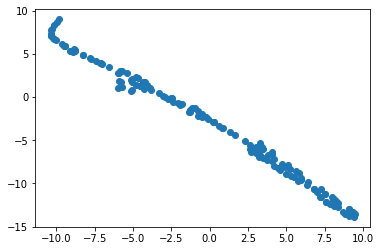

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
x_train_sne = tsne.fit_transform(x_train)

plt.scatter(x_train_sne[:,0], x_train_sne[:,1])

There aren't clear groupings in this examination, but going by larger gaps of white space it appears there are about 5 clusters, so we'll feed this to our agglomerative clustering.

In [50]:
from sklearn.cluster import AgglomerativeClustering


ac = AgglomerativeClustering(n_clusters = 5, linkage='ward')
ct = pd.crosstab(y_train['Successful Location'], ac.fit_predict(x_train))
ct

col_0,0,1,2,3,4
Successful Location,,,,,
False,106,11,7,0,0
True,13,7,3,1,1


But this scheme fails to seperate out any predominantly Successful segmentation, so we are inclined to settle on our prior kmeans clusters as the best indicator for our customer segmentation. First however we will try one more clustering algorithm that may identify different cluster shapes, we'll do a run with DBSCAN and we'll use adjusted_rand_score to rate different parameters for our implementation.

In [55]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from numpy.random import RandomState

rand_state = RandomState(seed=42)

for i in np.arange(0.1,2,0.1):
    dbs = DBSCAN(eps=i)
    pred = dbs.fit_predict(x_train_pca)
    pred = pred[pred != -1] # remove noise points
    cluster_count = len(np.unique(pred))
    rand_clustering = rand_state.randint(low=0, high=cluster_count, size=len(pred))
    print("eps: {}, cluster_count: {}, rand_score: {}".format(
        i, cluster_count, adjusted_rand_score(pred, rand_clustering)))


eps: 0.1, cluster_count: 0, rand_score: 1.0
eps: 0.2, cluster_count: 0, rand_score: 1.0
eps: 0.30000000000000004, cluster_count: 0, rand_score: 1.0
eps: 0.4, cluster_count: 0, rand_score: 1.0
eps: 0.5, cluster_count: 0, rand_score: 1.0
eps: 0.6, cluster_count: 1, rand_score: 1.0
eps: 0.7000000000000001, cluster_count: 2, rand_score: -0.051546391752577345
eps: 0.8, cluster_count: 2, rand_score: -0.03125
eps: 0.9, cluster_count: 2, rand_score: -0.012124669128998936
eps: 1.0, cluster_count: 1, rand_score: 1.0
eps: 1.1, cluster_count: 1, rand_score: 1.0
eps: 1.2000000000000002, cluster_count: 1, rand_score: 1.0
eps: 1.3000000000000003, cluster_count: 1, rand_score: 1.0
eps: 1.4000000000000001, cluster_count: 1, rand_score: 1.0
eps: 1.5000000000000002, cluster_count: 1, rand_score: 1.0
eps: 1.6, cluster_count: 1, rand_score: 1.0
eps: 1.7000000000000002, cluster_count: 1, rand_score: 1.0
eps: 1.8000000000000003, cluster_count: 1, rand_score: 1.0
eps: 1.9000000000000001, cluster_count: 1, ran

But our rand scores are negative even for runs where we achieve a clustering, so we should continue to stick with kmeans.